In [1]:
%pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cpu.html -qqq
%pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cpu.html -qqq
%pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.8.0+cpu.html -qqq
%pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.8.0+cpu.html -qqq
%pip install torch-geometric -qqq
%pip install torch==1.8.0 -qqq

%pip install pytorch_lightning -qqq

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

Processing...
Done!


In [3]:
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(50 * '=')

data = dataset[0]

print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Is undirected: {data.is_undirected()}')

Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Number of training nodes: 140
Training node label rate: 0.05
Is undirected: True


In [5]:
print(data.x.shape)
data.x[0][:50]

torch.Size([2708, 1433])


tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [6]:
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [7]:
print(len(data.test_mask) == data.num_nodes)
data.test_mask

True


tensor([False, False, False,  ...,  True,  True,  True])

In [8]:
data.edge_index.t()

tensor([[   0,  633],
        [   0, 1862],
        [   0, 2582],
        ...,
        [2707,  598],
        [2707, 1473],
        [2707, 2706]])

In [9]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # Initialize the layers
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Second Message Passing Layer
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Output layer
        x = F.softmax(self.out(x), dim=1)
        return x


model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
  (out): Linear(in_features=16, out_features=7, bias=True)
)


In [10]:
model = GCN(hidden_channels=16)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data = data.to(device)

In [12]:
# Initialize Optimizer
learning_rate = 0.01
decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate,
                             weight_decay=decay)
# Define loss function (CrossEntropyLoss for Classification Problems with probability distributions)
criterion = torch.nn.CrossEntropyLoss()

In [13]:
def train():
      model.train()
      optimizer.zero_grad()
      # Use all data as input, because all nodes have node features
      out = model(data.x, data.edge_index)
      # Only use nodes with labels available for loss calculation --> mask
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

In [14]:
def test():
      model.eval()
      out = model(data.x, data.edge_index)
      # Use the class with highest probability.
      pred = out.argmax(dim=1)
      # Check against ground-truth labels.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]
      # Derive ratio of correct predictions.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
      return test_acc

In [15]:
losses = []
for epoch in range(0, 1001):
    loss = train()
    losses.append(loss)
    if epoch % 100 == 0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 000, Loss: 1.9461
Epoch: 100, Loss: 1.8616
Epoch: 200, Loss: 1.7218
Epoch: 300, Loss: 1.6939
Epoch: 400, Loss: 1.6404
Epoch: 500, Loss: 1.5497
Epoch: 600, Loss: 1.4927
Epoch: 700, Loss: 1.4560
Epoch: 800, Loss: 1.4087
Epoch: 900, Loss: 1.3648
Epoch: 1000, Loss: 1.3222


/Users/quyenlinhta/.conda/envs/node-classification-geopytorch/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

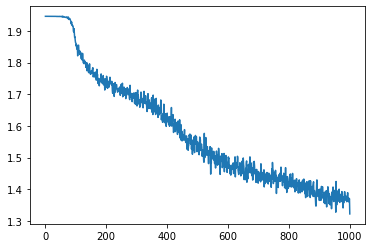

In [17]:
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
loss_indices = [i for i,l in enumerate(losses_float)]
plt = sns.lineplot(loss_indices, losses_float)
plt

In [18]:
#Test metric
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7030


torch.Size([2708, 7])


<AxesSubplot:>

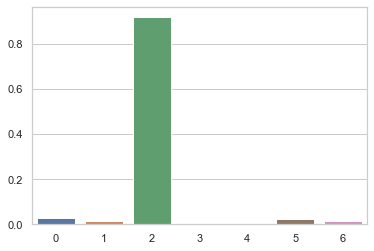

In [20]:
import numpy as np
sample = 9
sns.set_theme(style="whitegrid")
print(model(data.x, data.edge_index).shape)
pred = model(data.x, data.edge_index)
sns.barplot(x=np.array(range(7)), y=pred[sample].detach().cpu().numpy())

In [21]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np


def plt2arr(fig):
    rgb_str = fig.canvas.tostring_rgb()
    (w, h) = fig.canvas.get_width_height()
    rgba_arr = np.fromstring(rgb_str, dtype=np.uint8, sep='').reshape((w, h, -1))
    return rgba_arr


def visualize(h, color, epoch):
    fig = plt.figure(figsize=(5, 5), frameon=False)
    fig.suptitle(f'Epoch = {epoch}')
    # Fit TSNE with 2 components
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    # Create scatterplot from embeddings
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0],
                z[:, 1],
                s=70,
                c=color.detach().cpu().numpy(),
                cmap="Set2")
    fig.canvas.draw()

    # Convert to numpy
    return plt2arr(fig)


# Reset the previously trained model weights
for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()

TSNE Visualization finished.


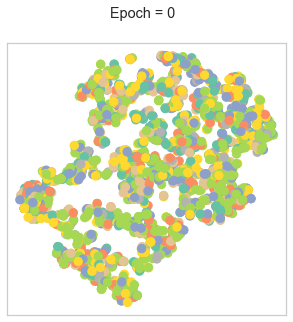

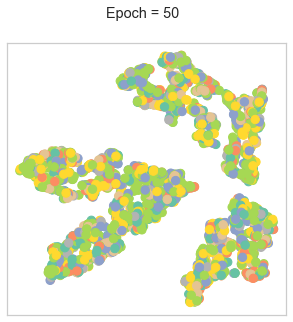

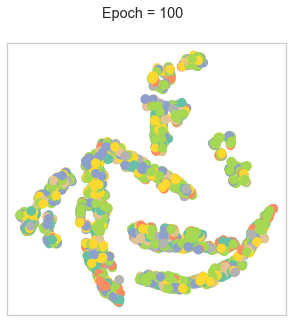

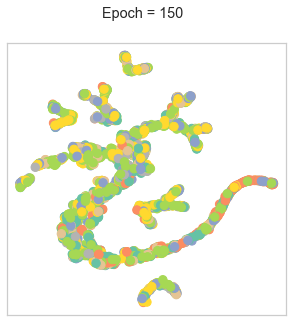

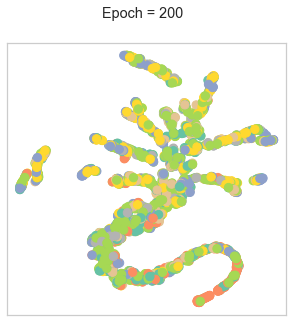

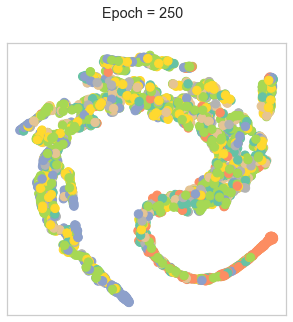

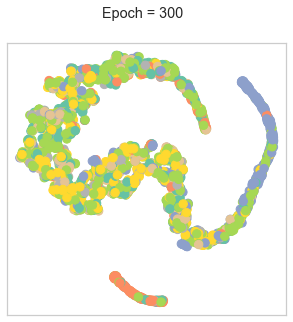

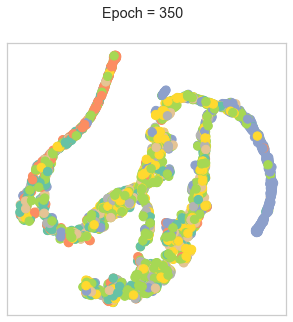

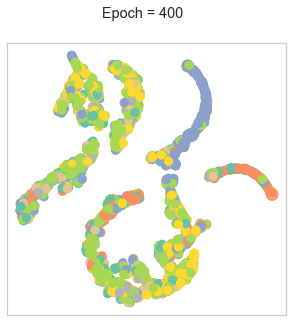

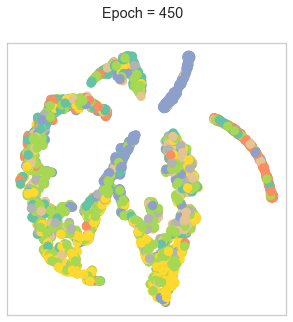

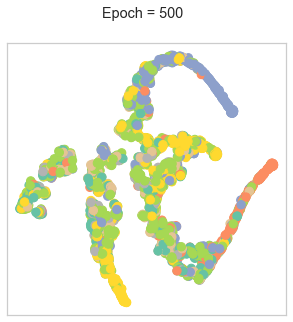

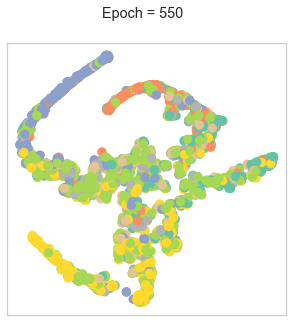

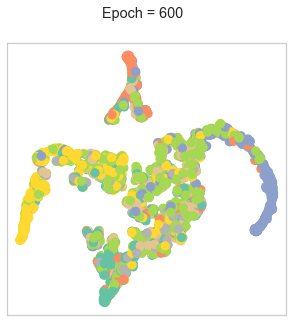

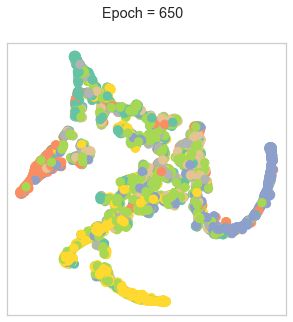

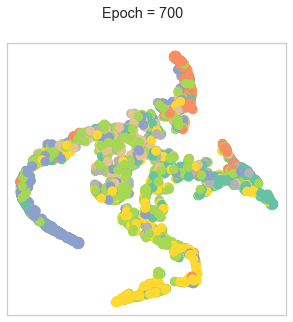

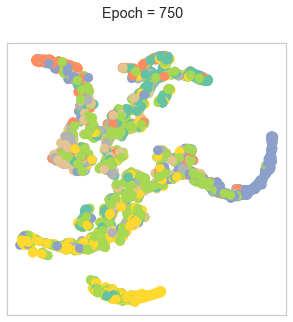

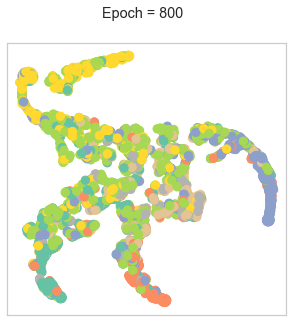

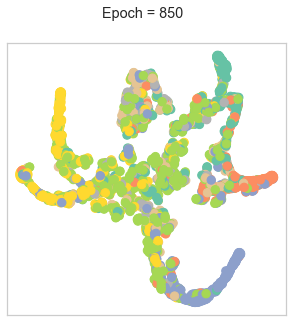

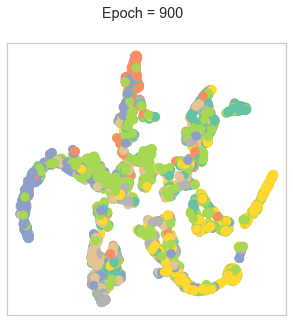

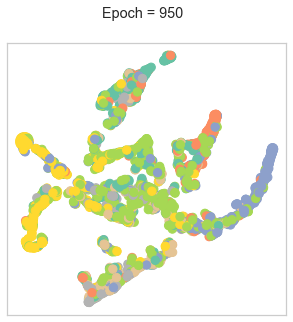

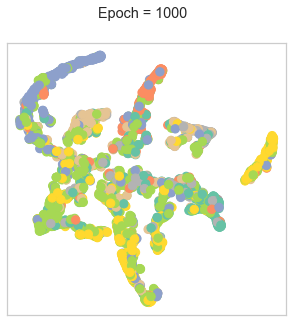

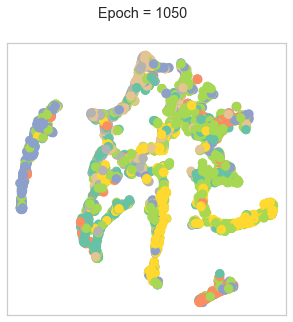

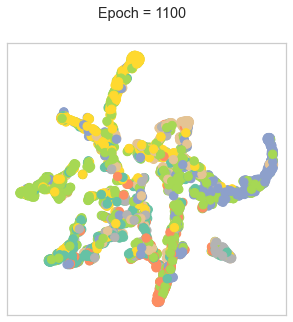

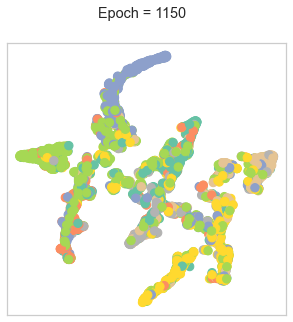

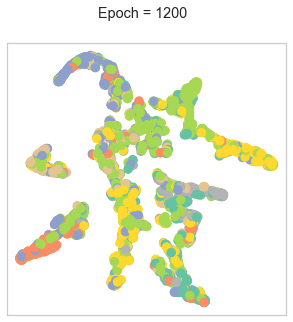

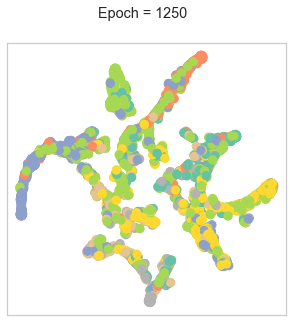

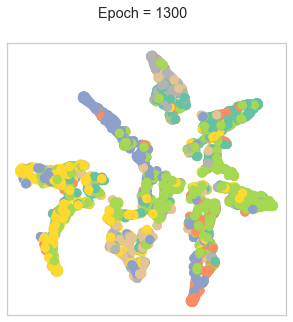

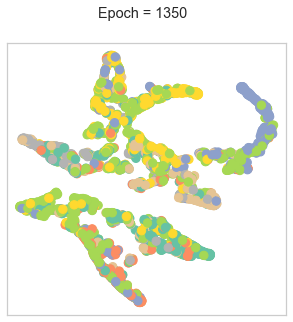

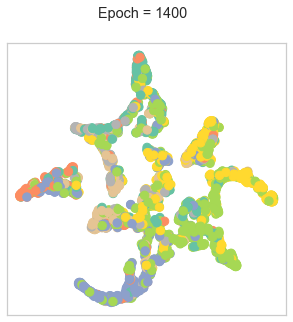

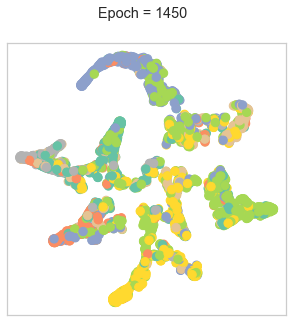

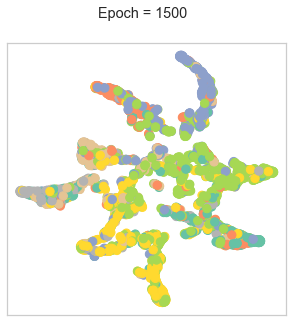

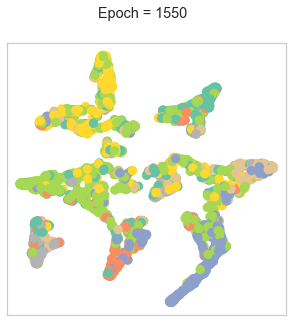

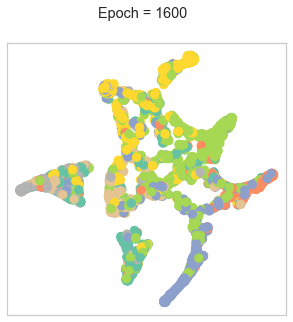

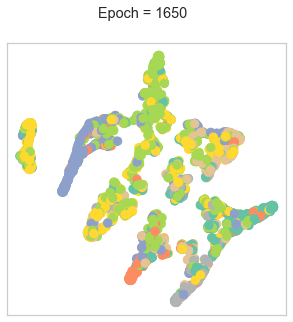

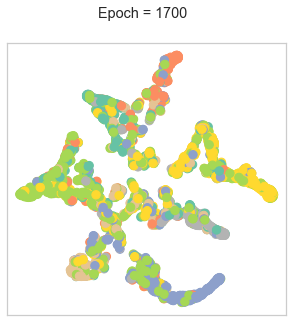

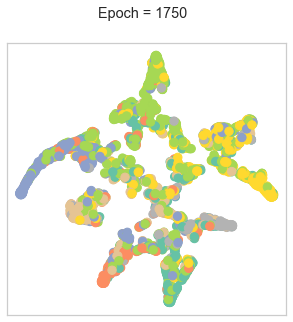

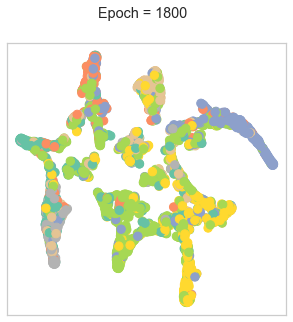

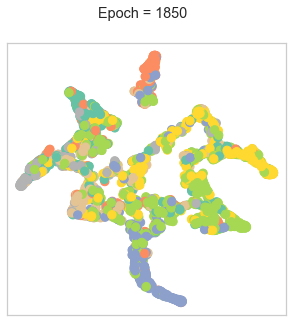

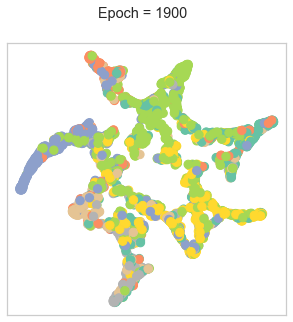

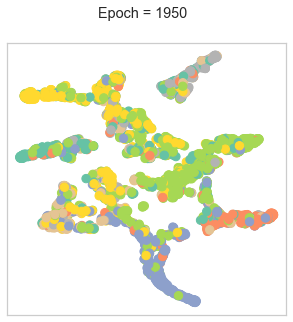

In [22]:
import warnings
warnings.filterwarnings('ignore')

# Train the model and save visualizations
images = []
for epoch in range(0, 2000):
    loss = train()
    if epoch % 50 == 0:
      out = model(data.x, data.edge_index)
      images.append(visualize(out, color=data.y, epoch=epoch))
print("TSNE Visualization finished.")

In [23]:
!pip install moviepy

     |████████████████████████████████| 388 kB 799 kB/s eta 0:00:01
  Using cached decorator-4.4.2-py2.py3-none-any.whl (9.2 kB)
     |████████████████████████████████| 3.3 MB 63.7 MB/s eta 0:00:01
     |████████████████████████████████| 22.5 MB 1.1 MB/s  eta 0:00:01
  Using cached Pillow-8.4.0-cp36-cp36m-macosx_10_10_x86_64.whl (3.0 MB)
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110743 sha256=183e200357e7d66ba3a4a4a97709636171915114788045e3ca1412bdb6cd62b2
  Stored in directory: /Users/quyenlinhta/Library/Caches/pip/wheels/be/dc/17/8b4d5a63bcd05dc44db7da57e193372ccd333617293f9deebe
Successfully built moviepy
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.3.1
    Uninstalling Pillow-8.3.1:
      Successfully uninstalled Pillow-8.3.1
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1


In [24]:
from moviepy.editor import ImageSequenceClip
fps = 1
filename = "embeddings.gif"
clip = ImageSequenceClip(images, fps=fps)
clip.write_gif(filename, fps=fps)

MoviePy - Building file embeddings.gif with imageio.


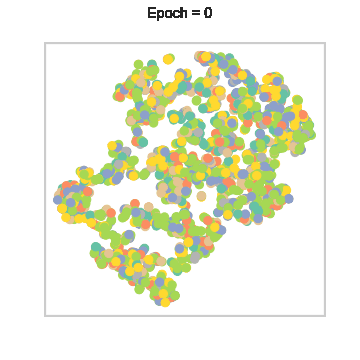

In [25]:
from IPython.display import Image
with open('embeddings.gif','rb') as f:
    display(Image(data=f.read(), format='png'))